In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import combinations
from scipy.stats import kendalltau

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
plt.style.use('seaborn')
rc('text', usetex=False)
%matplotlib inline

In [3]:
import logging
logging.basicConfig(level=logging.NOTSET)

In [4]:
class BatchLogistic:
    def __init__(self, theta, alpha, lambda_reg=0):
        # Initialize model object with given theta, alpha (learning rate),
        # and lambda_reg (regularization hyperparameter)
        self.theta = np.array(theta)
        self.alpha = alpha
        self.lambda_reg = lambda_reg
        
    def sigmoid(self, X, theta):
        # Sigmoid function to calculate probability of weight gain from feature matrix X and theta vector
        return 1 / (1 + np.exp(-X @ theta))
    
    def fit(self, X, y, n_iter):
        self.avg_log_likelihoods = []
        self.thetas = []
        
        for i in range(n_iter):
            # Record theta for every iteration
            self.thetas.append(self.theta)
            
            prob = self.sigmoid(X, self.theta) # Step 1      
            # Record average log-likelihood for every iteration
            if np.all(prob != 0) or np.all(prob != 1):
                self.avg_log_likelihood = (y @ np.log(prob) + (1 - y) @ np.log(1 - prob)) / len(y)
                self.avg_log_likelihoods.append(self.avg_log_likelihood)
            
            # Calculate regularization term for ridge regression
            reg_term = self.lambda_reg * self.theta
            # First feature (intercept) is not regularized
            reg_term[0] = 0
            
            self.gradient = (y - prob) @ X - reg_term # Step 2, note the extra reg_term subtracted at the end
            self.theta = self.theta + self.alpha * self.gradient # Step 3
        # Record difference in average log-likelihood for the last iteration
        self.last_avg_log_likelihood_diff = self.avg_log_likelihoods[-1] - self.avg_log_likelihoods[-2]
        self.thetas = np.array(self.thetas)
            
    def predict(self, X, threshold=0.5):
        # Return predicted labels when using trained model on X feature matrix
        return (self.sigmoid(X, self.theta) > threshold).astype(int)
    
    def predict_proba(self, X):
        # Return predicted probability of weight gain using trained model on X feature matrix
        return self.sigmoid(X, self.theta)

## Import scores from CSV

In [5]:
male_scores = pd.read_csv('https://raw.githubusercontent.com/dknguyengit/skate_predict/master/scores/trimmed_male.csv')
female_scores = pd.read_csv('https://raw.githubusercontent.com/dknguyengit/skate_predict/master/scores/trimmed_female.csv')

## Split data into train and test

In [6]:
years_before_last = range(2005, 2018)
year_seed = np.random.RandomState(seed=42)
train_years = sorted(list(year_seed.choice(years_before_last, size=10, replace=False)))
test_years = sorted([year for year in years_before_last if year not in train_years] + [2018])
train_years, test_years

([2005, 2006, 2007, 2009, 2010, 2012, 2013, 2014, 2016, 2017],
 [2008, 2011, 2015, 2018])

In [7]:
season_male = male_scores.loc[male_scores['event']!='WR']
world_male = male_scores.loc[male_scores['event']=='WR']
season_female = female_scores.loc[female_scores['event']!='WR']
world_female = female_scores.loc[female_scores['event']=='WR']

## Implement kendall tau metrics

In [8]:
def return_ranking(skater_scores, world_scores):
    skater_scores = skater_scores.sort_values(ascending=False)
    world_scores = world_scores.sort_values(ascending=False)
    skater_ranking = list(skater_scores.index.intersection(world_scores.index))
    world_ranking = list(world_scores.index.intersection(skater_scores.index))
    return skater_ranking, world_ranking

In [9]:
def calculate_kendall_tau(skater_ranking, world_ranking, verbose=True):
    skater_pairs = set(combinations(skater_ranking, 2))
    world_pairs = set(combinations(world_ranking, 2))
    n_pairs = len(skater_pairs)
    n_concordant_pairs = len(set(skater_pairs) & set(world_pairs))
    if verbose:
      print(f'There are {n_concordant_pairs} concordant_pairs out of {n_pairs} pairs')
    tau = (2 * n_concordant_pairs - n_pairs) / n_pairs
    return tau 

## Average skate score model

In [10]:
def get_yearly_scores(year, season_scores, world_scores):
    yearly_season_scores = season_scores.loc[season_scores['year']==year].copy()
    yearly_world_scores = world_scores.loc[world_scores['year']==year, ['name', 'score']].set_index('name').squeeze()
    return yearly_season_scores, yearly_world_scores

In [11]:
season_scores, world_scores = get_yearly_scores(2017, season_male, world_male)

In [12]:
season_avg = season_scores.groupby('name')['score'].mean().sort_values(ascending=False)
season_avg.head()

name
Yuzuru, HANYU        290.5350
Javier, FERNANDEZ    285.4925
Shoma, UNO           283.7425
Nathan, CHEN         281.0050
Patrick, CHAN        270.3500
Name: score, dtype: float64

In [13]:
avg_ranking, world_ranking = return_ranking(season_avg, world_scores)
calculate_kendall_tau(avg_ranking, world_ranking)

There are 234 concordant_pairs out of 276 pairs


0.6956521739130435

Result agrees with kendalltau from scipy

In [14]:
season_numeric_rank = list(range(len(avg_ranking)))
world_numeric_rank = [avg_ranking.index(skater) for skater in world_ranking]
kendalltau(season_numeric_rank, world_numeric_rank)

KendalltauResult(correlation=0.6956521739130435, pvalue=1.9126097800691154e-06)

RMSE with mean model

In [15]:
score_comparison = pd.merge(season_scores, season_avg.to_frame(), left_on='name', right_index=True, suffixes=['', '_avg'])
score_comparison['sq_error'] = (score_comparison['score'] - score_comparison['score_avg'])**2
np.sqrt(score_comparison['sq_error'].mean())

10.271546837961868

### Refactored

In [16]:
class Model:
    def __init__(self):
        self.skater_scores = None
        self.model_ranking = None
        self.world_ranking = None
        self.predicted_season_scores = None
    
    def evaluate_rmse(self, season_scores):
        squared_errors = (season_scores['score'].values - self.predicted_season_scores)**2
        rmse = np.sqrt(squared_errors.mean())
        return rmse
        
    def evaluate_kendall_tau(self, world_scores, verbose=True):
        def return_ranking(skater_scores, world_scores):
            skater_scores = skater_scores.sort_values(ascending=False)
            world_scores = world_scores.sort_values(ascending=False)
            skater_ranking = list(skater_scores.index.intersection(world_scores.index))
            world_ranking = list(world_scores.index.intersection(skater_scores.index))
            return skater_ranking, world_ranking
    
        def calculate_kendall_tau(skater_ranking, world_ranking, verbose=verbose):
            skater_pairs = set(combinations(skater_ranking, 2))
            world_pairs = set(combinations(world_ranking, 2))
            n_pairs = len(skater_pairs)
            n_concordant_pairs = len(set(skater_pairs) & set(world_pairs))
            if verbose:
                print(f'There are {n_concordant_pairs} concordant_pairs out of {n_pairs} pairs')
            tau = (2 * n_concordant_pairs - n_pairs) / n_pairs
            return tau, n_concordant_pairs, n_pairs
        
        skater_scores = self.skater_scores.squeeze()
        self.model_ranking, self.world_ranking = return_ranking(skater_scores, world_scores)
        return calculate_kendall_tau(self.model_ranking, self.world_ranking)
    
    def evaluate_over_years(self, years, season_df, world_df, **kwargs):
        taus = []
        rmses = []
        concordant_pairs = []
        n_pairs = []
        for year in years:
            season_scores, world_scores = get_yearly_scores(year, season_df, world_df)
            self.fit(season_scores, **kwargs)
            rmse = self.evaluate_rmse(season_scores)
            tau, concordant_pair, n_pair = self.evaluate_kendall_tau(world_scores, verbose=False)
            
            rmses.append(rmse)
            taus.append(tau)
            concordant_pairs.append(concordant_pair)
            n_pairs.append(n_pair)
        return pd.DataFrame({'year': years, 'rmse': rmses, 
                             'tau': taus, 'conc': concordant_pairs, 'pairs': n_pairs}).sort_values(by='year')

In [17]:
class AverageScore(Model):
    def __init__(self):
        super().__init__()
        
    def predict_season_scores(self, season_scores):
        self.predicted_season_scores = self.skater_scores.loc[season_scores['name']].values
    
    def fit(self, season_scores):
        self.skater_scores = season_scores.groupby('name')['score'].mean()
        self.skater_scores.sort_values(ascending=False, inplace=True)
        self.predict_season_scores(season_scores)        

In [18]:
avg = AverageScore()
avg_train_eval = avg.evaluate_over_years(train_years, season_male, world_male)
avg_train_eval

,year,rmse,tau,conc,pairs
0,2005,10.357050,0.647619,173,210
1,2006,9.749220,0.691700,214,253
2,2007,8.151442,0.630435,225,276
3,2009,8.557905,0.601449,221,276
4,2010,11.139947,0.714286,198,231
5,2012,9.424702,0.604743,203,253
6,2013,9.965307,0.604743,203,253
7,2014,10.563519,0.819048,191,210
8,2016,12.694622,0.695652,234,276
9,2017,10.271547,0.695652,234,276


## Normalized mean model

In [19]:
season_scores['score_normed'] = season_scores.groupby('event')['score'].transform(lambda score: (score - score.mean()) / score.std())

In [20]:
season_normed_avg = season_scores.groupby('name')['score_normed'].mean().sort_values(ascending=False)
season_normed_avg.head()

name
Yuzuru, HANYU        1.668135
Javier, FERNANDEZ    1.440927
Shoma, UNO           1.326910
Nathan, CHEN         1.104096
Patrick, CHAN        1.090843
Name: score_normed, dtype: float64

In [21]:
normed_avg_ranking, world_ranking = return_ranking(season_normed_avg, world_scores)
calculate_kendall_tau(normed_avg_ranking, world_ranking)

There are 222 concordant_pairs out of 276 pairs


0.6086956521739131

### Refactored

In [22]:
class NormedAverageScore(Model):
    def __init__(self):
        super().__init__()
    
    def predict_season_scores(self, season_scores, event_stds, event_means):
        self.predicted_season_scores = (self.skater_scores.loc[season_scores['name']] * event_stds + event_means).values
        
    def fit(self, season_scores):
        season_scores = season_scores.copy()
        event_means = season_scores.groupby('event')['score'].mean().loc[season_scores['event']].values
        event_stds = season_scores.groupby('event')['score'].std().loc[season_scores['event']].values
        season_scores['score_normed'] = (season_scores['score'] - event_means) / event_stds
        
        self.skater_scores = season_scores.groupby('name')['score_normed'].mean()
        self.skater_scores.sort_values(ascending=False, inplace=True)
        
        self.predict_season_scores(season_scores, event_stds, event_means)        

In [23]:
normavg = NormedAverageScore()
normavg_train_eval = normavg.evaluate_over_years(train_years, season_male, world_male)
normavg_train_eval

,year,rmse,tau,conc,pairs
0,2005,14.221490,0.580952,166,210
1,2006,12.650485,0.636364,207,253
2,2007,12.556444,0.630435,225,276
3,2009,14.067104,0.615942,223,276
4,2010,12.898410,0.593074,184,231
5,2012,12.437599,0.494071,189,253
6,2013,15.373393,0.494071,189,253
7,2014,15.685363,0.685714,177,210
8,2016,18.328151,0.615942,223,276
9,2017,15.921112,0.608696,222,276


## Linear model

In [24]:
dummies = pd.get_dummies(season_scores[['name', 'event']], prefix=['', ''], prefix_sep='', drop_first=True)
unique_skaters = season_scores['name'].unique()
unique_events = season_scores['event'].unique()

dummies_skater_count = len(unique_skaters) - 1
dummies_skaters = dummies.columns[:dummies_skater_count]
dummies_events = dummies.columns[dummies_skater_count:]

dropped_skater = list(set(unique_skaters) - set(dummies_skaters))[0]
dropped_event = list(set(unique_events) - set(dummies_events))[0]

In [25]:
X = dummies.values
X = np.insert(X, 0, 1, axis=1)
y = season_scores['score'].values
coefs_linear = np.linalg.inv(X.T @ X) @ (X.T @ y)
coefs_linear[:10]

array([ 262.83064921,  -58.77196129,  -27.74060019,  -38.56497213,
        -16.6525816 , -100.78064921,  -36.58476179,    3.9048582 ,
        -45.88750626,  -35.41149857])

In [26]:
linear_rmse = np.sqrt(np.mean((y - X @ coefs_linear)**2))
linear_rmse

8.838699611397724

Double check with sklearn's LinearRegression and mean_square_error

In [27]:
lin = LinearRegression(fit_intercept=False)
lin.fit(X, y)
lin.coef_[:10], lin.intercept_

(array([ 262.83064921,  -58.77196129,  -27.74060019,  -38.56497213,
         -16.6525816 , -100.78064921,  -36.58476179,    3.9048582 ,
         -45.88750626,  -35.41149857]), 0.0)

In [28]:
np.sqrt(mean_squared_error(y, X @ lin.coef_))

8.838699611397724

Add dropped baseline skater and event

In [29]:
skater_scores = pd.Series(coefs_linear[1:dummies_skater_count+1], index=dummies_skaters)
event_scores = pd.Series(coefs_linear[dummies_skater_count+1:], index=dummies_events)

skater_scores[dropped_skater] = 0
event_scores[dropped_skater] = 0

skater_scores.sort_values(ascending=False, inplace=True)
event_scores.sort_values(ascending=False, inplace=True)

In [30]:
linear_ranking, world_ranking = return_ranking(skater_scores, world_scores)

In [31]:
calculate_kendall_tau(linear_ranking, world_ranking)

There are 239 concordant_pairs out of 276 pairs


0.7318840579710145

### Refactored

In [32]:
class Linear(Model):
    def __init__(self, lambda_reg=0):
        super().__init__()
        self.lambda_reg = lambda_reg
        self.event_scores = None
        self.baseline = None
        
    def find_coefs(self, X, y):
        L = np.identity(n=len(X.T))
        L[0, 0] = 0
        coefs = np.linalg.inv(X.T @ X + self.lambda_reg * L) @ (X.T @ y)
        return coefs
    
    def predict_season_scores(self, season_scores):
        broadcasted_skater_scores = self.skater_scores.loc[season_scores['name']].values
        broadcasted_event_scores = self.event_scores.loc[season_scores['event']].values
        self.predicted_season_scores = broadcasted_skater_scores + broadcasted_event_scores + self.baseline
        
    def fit(self, season_scores):
        dummies = pd.get_dummies(season_scores[['name', 'event']], prefix=['', ''], prefix_sep='', drop_first=True)
        unique_skaters = season_scores['name'].unique()
        unique_events = season_scores['event'].unique()
        
        dummies_skater_count = len(unique_skaters) - 1
        dummies_skaters = dummies.columns[:dummies_skater_count]
        dummies_events = dummies.columns[dummies_skater_count:]

        dropped_skater = list(set(unique_skaters) - set(dummies_skaters))[0]
        dropped_event = list(set(unique_events) - set(dummies_events))[0]

        X = dummies.values
        X = np.insert(X, 0, 1, axis=1)
        y = season_scores['score'].values
        coefs = self.find_coefs(X, y)

        self.baseline = coefs[0]    
        self.skater_scores = pd.Series(coefs[1:dummies_skater_count+1], index=dummies_skaters)
        self.event_scores = pd.Series(coefs[dummies_skater_count+1:], index=dummies_events)
        self.skater_scores[dropped_skater] = 0
        self.event_scores[dropped_event] = 0
        
        self.skater_scores.sort_values(ascending=False, inplace=True)
        self.event_scores.sort_values(ascending=False, inplace=True)        
        
        self.predict_season_scores(season_scores)

In [33]:
linear = Linear()
linear_train_eval = linear.evaluate_over_years(train_years, season_male, world_male)
linear_train_eval

,year,rmse,tau,conc,pairs
0,2005,8.555327,0.666667,175,210
1,2006,7.883763,0.620553,205,253
2,2007,7.578146,0.601449,221,276
3,2009,8.110917,0.586957,219,276
4,2010,9.798364,0.696970,196,231
5,2012,8.144647,0.541502,195,253
6,2013,9.047367,0.691700,214,253
7,2014,8.781486,0.809524,190,210
8,2016,11.053367,0.673913,231,276
9,2017,8.838700,0.731884,239,276


In [34]:
linear_train_eval['tau'].mean()

0.662111801242236

In [35]:
for lambda_reg in [0, 0.001, 0.01, 0.1, 1, 10, 100]:
    linear = Linear(lambda_reg=lambda_reg)
    linear_train_eval = linear.evaluate_over_years(train_years, season_male, world_male)
    print(lambda_reg, linear_train_eval['rmse'].mean(), linear_train_eval['tau'].mean())

0 8.779208324854647 0.662111801242236
0.001 8.782755125399937 0.6619499341238472
0.01 8.925173433616132 0.6596894409937888
0.1 9.788140496081605 0.6537982307547525
1 15.206034467688387 0.637331074722379
10 27.042844923858063 0.6193073593073594
100 32.34814733209342 0.6250574063617542


## Log-linear Model

In [36]:
coefs_log_linear = np.linalg.inv(X.T @ X) @ (X.T @ np.log(y))
coefs_log_linear[:10]

array([ 5.57079276, -0.2537603 , -0.11337176, -0.15854428, -0.06450661,
       -0.48288783, -0.14988655,  0.01455732, -0.19499875, -0.14436472])

In [37]:
log_linear_rmse = np.exp(np.sqrt(np.mean((np.log(y) - X @ coefs_log_linear)**2)))
log_linear_rmse

1.0376683361937684

In [38]:
skater_scores = pd.Series(coefs_log_linear[1:dummies_skater_count+1], index=dummies_skaters)
event_scores = pd.Series(coefs_log_linear[dummies_skater_count+1:], index=dummies_events)

skater_scores[dropped_skater] = 0
event_scores[dropped_skater] = 0

skater_scores.sort_values(ascending=False, inplace=True)
event_scores.sort_values(ascending=False, inplace=True)

skater_scores = np.exp(skater_scores)
event_scores = np.exp(event_scores)

In [39]:
skater_scores

Yuzuru, HANYU                  1.154228
Nathan, CHEN                   1.110905
Javier, FERNANDEZ              1.108103
Shoma, UNO                     1.105957
Patrick, CHAN                  1.062009
Denis, TEN                     1.059121
Boyang, JIN                    1.014664
Adam, RIPPON                   1.000000
Jason, BROWN                   0.953747
Sergei, VORONOV                0.947786
Alexei, BYCHENKO               0.937530
Mikhail, KOLYADA               0.933023
Takahito, MURA                 0.932946
Max, AARON                     0.928603
Kevin, REYNOLDS                0.912023
Maxim, KOVTUN                  0.911407
Misha, GE                      0.906351
Keiji, TANAKA                  0.905789
Nam, NGUYEN                    0.898441
Alexander, PETROV              0.892819
Jorik, HENDRICKX               0.891376
Moris, KVITELASHVILI           0.880480
Timothy, DOLENSKY              0.877638
Han, YAN                       0.875485
Gordei, GORSHKOV               0.869104


Double check with sklearn's LinearRegression and mean_square_error

In [40]:
lin = LinearRegression(fit_intercept=False)
lin.fit(X, np.log(y))
lin.coef_[:10], lin.intercept_

(array([ 5.57079276, -0.2537603 , -0.11337176, -0.15854428, -0.06450661,
        -0.48288783, -0.14988655,  0.01455732, -0.19499875, -0.14436472]), 0.0)

In [41]:
np.exp(np.sqrt(mean_squared_error(np.log(y), X @ lin.coef_)))

1.0376683361937684

Evaluate Kendall's Tau

In [42]:
log_linear_ranking, world_ranking = return_ranking(skater_scores, world_scores)

In [43]:
calculate_kendall_tau(linear_ranking, world_ranking)

There are 239 concordant_pairs out of 276 pairs


0.7318840579710145

### Refactor

In [44]:
class LogLinear(Linear):
    def __init__(self, lambda_reg=0):
        super().__init__(lambda_reg)
        
    def find_coefs(self, X, y):
        L = np.identity(n=len(X.T))
        L[0, 0] = 0
        coefs = np.linalg.inv(X.T @ X + self.lambda_reg * L) @ (X.T @ np.log(y))
        return coefs
    
    def predict_season_scores(self, season_scores):
        broadcasted_skater_scores = self.skater_scores.loc[season_scores['name']].values
        broadcasted_event_scores = self.event_scores.loc[season_scores['event']].values
        self.log_predicted_season_scores = broadcasted_skater_scores + broadcasted_event_scores + self.baseline
        self.predicted_season_scores = np.exp(self.log_predicted_season_scores)
        
    def evaluate_rmse(self, season_scores):
        log_squared_errors = (np.log(season_scores['score'].values) - self.log_predicted_season_scores)**2
        log_rmse = np.sqrt(log_squared_errors.mean())
        rmse = np.exp(log_rmse)
        return rmse

In [45]:
loglinear = LogLinear()
loglinear_train_eval = loglinear.evaluate_over_years(train_years, season_male, world_male)
loglinear_train_eval

,year,rmse,tau,conc,pairs
0,2005,1.051008,0.666667,175,210
1,2006,1.045100,0.636364,207,253
2,2007,1.042015,0.601449,221,276
3,2009,1.042605,0.565217,216,276
4,2010,1.050437,0.714286,198,231
5,2012,1.040119,0.525692,193,253
6,2013,1.041869,0.683794,213,253
7,2014,1.040164,0.828571,192,210
8,2016,1.048652,0.673913,231,276
9,2017,1.037668,0.731884,239,276


In [46]:
loglinear_train_eval['tau'].mean()

0.6627837380011293

In [47]:
avg.evaluate_over_years(train_years, season_male, world_male)

,year,rmse,tau,conc,pairs
0,2005,10.357050,0.647619,173,210
1,2006,9.749220,0.691700,214,253
2,2007,8.151442,0.630435,225,276
3,2009,8.557905,0.601449,221,276
4,2010,11.139947,0.714286,198,231
5,2012,9.424702,0.604743,203,253
6,2013,9.965307,0.604743,203,253
7,2014,10.563519,0.819048,191,210
8,2016,12.694622,0.695652,234,276
9,2017,10.271547,0.695652,234,276


In [48]:
for lambda_reg in [0, 0.001, 0.01, 0.1, 1, 10, 100]:
    loglinear = LogLinear(lambda_reg=lambda_reg)
    loglinear_train_eval = loglinear.evaluate_over_years(train_years, season_male, world_male)
    print(lambda_reg, loglinear_train_eval['rmse'].mean(), loglinear_train_eval['tau'].mean())

0 1.043963617896676 0.6627837380011293
0.001 1.043998390360219 0.6618520609824958
0.01 1.0453133728174064 0.653425559947299
0.1 1.0518538623368006 0.6394089968003012
1 1.087499139738013 0.6379691323169585
10 1.162036606713829 0.6258008658008658
100 1.1945282438818492 0.6286598908338039


## Hybrid Model

In [49]:
season_table = pd.pivot_table(season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')
skater_names = list(season_table.index)
event_names = list(season_table.columns)

In [50]:
true_scores = season_table.values
skater_scores = np.full(len(skater_names), 0.5)
event_scores = np.full(len(event_names), 0.5)
bias = 0.5

alpha = 0.001
rmses = []

for _ in range(1000):
    diff = np.outer(skater_scores, event_scores) + bias - true_scores
    skater_gradients = np.nansum(diff * event_scores, axis=1)
    event_gradients = np.nansum(diff.T * skater_scores, axis=1)
    bias_gradient = np.nansum(diff)
    
    event_scores = event_scores - alpha * event_gradients
    skater_scores = skater_scores - alpha * skater_gradients
    bias = bias - alpha * bias_gradient
    rmse = np.sqrt(np.nanmean(diff**2))
    rmses.append(rmse)

In [51]:
rmse

8.863043830654695

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to Liberation Sans ('/usr/share/fonts/truetype/liberation2/LiberationSans-Regular.ttf') with score of 2.050000


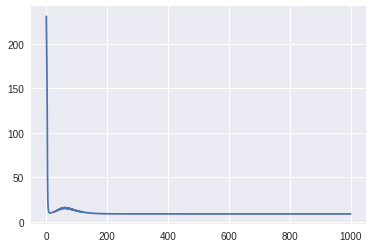

In [52]:
plt.plot(rmses)

In [53]:
hybrid_scores = pd.Series(skater_scores, index=skater_names)
hybrid_scores.sort_values(ascending=False, inplace=True)
hybrid_scores

Yuzuru, HANYU                  11.368899
Nathan, CHEN                   10.696464
Javier, FERNANDEZ              10.567736
Shoma, UNO                     10.562198
Patrick, CHAN                   9.981089
Denis, TEN                      9.937335
Boyang, JIN                     9.312272
Adam, RIPPON                    9.098090
Jason, BROWN                    8.460356
Sergei, VORONOV                 8.312755
Takahito, MURA                  8.193166
Alexei, BYCHENKO                8.080860
Mikhail, KOLYADA                8.037651
Max, AARON                      7.963655
Maxim, KOVTUN                   7.855620
Kevin, REYNOLDS                 7.832711
Misha, GE                       7.763226
Keiji, TANAKA                   7.620523
Nam, NGUYEN                     7.619910
Alexander, PETROV               7.541744
Jorik, HENDRICKX                7.515032
Moris, KVITELASHVILI            7.359118
Timothy, DOLENSKY               7.334442
Han, YAN                        7.329392
Daniel, SAMOHIN 

In [54]:
hybrid_ranking, world_ranking = return_ranking(hybrid_scores, world_scores)

In [55]:
calculate_kendall_tau(hybrid_ranking, world_ranking)

There are 238 concordant_pairs out of 276 pairs


0.7246376811594203

### Refactor

In [191]:
class Hybrid(Linear):
    def __init__(self, alpha, n_factors, lambda_reg=0):
        super().__init__(lambda_reg)
        self.alpha = alpha
        self.n_factors = n_factors
        
    def predict_season_scores(self, season_scores, bias=False):
        predicted_score_table = (self.skater_scores @ self.event_scores.T + self.baseline)
        if bias:
            predicted_score_table = predicted_score_table + self.skater_bias[:, np.newaxis] + self.event_bias
                                 
        predicted_score_table = pd.DataFrame(predicted_score_table,
                                            index=self.skater_names,
                                            columns=self.event_names)   
        predicted_score_stacked = predicted_score_table.stack()
        season_skater_event_index = season_scores.set_index(['name', 'event']).index
        self.predicted_season_scores = predicted_score_stacked.loc[season_skater_event_index].values
        
    def fit(self, season_scores, n_iter, seed=42, fixed_baseline=False, bias=False, verbose=False):
        if verbose:
            logging.disable(logging.NOTSET)
        else:
            logging.disable(logging.DEBUG)
        season_table = pd.pivot_table(season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')
        self.skater_names = list(season_table.index)
        self.event_names = list(season_table.columns)

        true_scores = season_table.values
        random_state = np.random.RandomState(seed=seed)
        self.skater_scores = random_state.random_sample((len(self.skater_names), self.n_factors))
        self.event_scores = random_state.random_sample((len(self.event_names), self.n_factors))
        self.baseline = season_scores['score'].mean() if fixed_baseline else 0.5
        self.skater_bias = random_state.random_sample(len(self.skater_names))
        self.event_bias = random_state.random_sample(len(self.event_names))

        self.rmses = []
        
        for iteration in range(n_iter):
            logging.debug(f'iteration: {iteration}')
            diff = self.skater_scores @ self.event_scores.T + self.baseline - true_scores
            if bias:
                diff = diff + self.skater_bias[:, np.newaxis] + self.event_bias
            
            for i in range(self.n_factors):
                logging.debug(f'factor: {i}')
                if not fixed_baseline:
                    logging.debug(f'baseline before: {self.baseline}')
                    baseline_gradient = np.nansum(diff)
                    self.baseline = self.baseline - self.alpha * baseline_gradient
                    logging.debug(f'baseline after: {self.baseline}')
                if bias:
                    logging.debug(f'skater_bias before: {self.event_bias}')
                    logging.debug(f'event_bias before: {self.skater_bias}')                    
                    self.skater_bias = self.skater_bias - self.alpha * (np.nansum(diff, axis=1) - self.lambda_reg * self.skater_bias)
                    self.event_bias = self.event_bias - self.alpha * (np.nansum(diff, axis=0) - self.lambda_reg * self.event_bias)
                    logging.debug(f'skater_bias after: {self.event_bias}')
                    logging.debug(f'event_bias after: {self.skater_bias}')   
                    
                logging.debug(f'skater_scores before\n{self.skater_scores}')
                logging.debug(f'event_scores before\n{self.event_scores}')                               
                skater_gradients = np.nansum(diff * self.event_scores[:, i], axis=1) + self.lambda_reg * self.skater_scores[:, i]
                event_gradients = np.nansum(diff.T * self.skater_scores[:, i], axis=1) + self.lambda_reg * self.event_scores[:, i] 
                logging.debug(f'skater_gradients\n{skater_gradients}')
                logging.debug(f'event_gradients\n{event_gradients}')
                
                self.skater_scores[:, i] = self.skater_scores[:, i] - self.alpha * skater_gradients
                self.event_scores[:, i] = self.event_scores[:, i] - self.alpha * event_gradients
                logging.debug(f'skater_scores after\n{self.skater_scores}')
                logging.debug(f'event_scores after\n{self.event_scores}')
                
            rmse = np.sqrt(np.nanmean(diff**2))
            self.rmses.append(rmse)
            
        self.predict_season_scores(season_scores)
        
        if bias:
            self.skater_scores = np.hstack([self.skater_bias[:, np.newaxis], self.skater_scores])
            self.event_scores = np.hstack([self.event_bias[:, np.newaxis], self.event_scores])
        
        self.skater_scores = pd.DataFrame(self.skater_scores, index=self.skater_names)
        self.event_scores = pd.DataFrame(self.event_scores, index=self.event_names)
        
        self.skater_scores.sort_values(by=0, ascending=False, inplace=True)
        self.event_scores.sort_values(by=0, ascending=False, inplace=True)
        

    def evaluate_rmse_over_years(self, years, season_df, world_df, **kwargs):
        # Evaluate RMSE (without evaluating tau) over years
        rmses = []
        for year in years:
            season_scores, world_scores = get_yearly_scores(year, season_df, world_df)
            self.fit(season_scores, **kwargs)
            rmse = self.evaluate_rmse(season_scores)
            rmses.append(rmse)
        return pd.DataFrame({'year': years, 'rmse': rmses}).sort_values(by='year')

### Single latent factor

In [202]:
hybrid = Hybrid(alpha=0.001, n_factors=1)
hybrid.fit(season_scores, n_iter=1000, seed=42, bias=False)

Train over all years in training set

In [63]:
hybrid = Hybrid(alpha=0.001, n_factors=1)
hybrid_train_eval = hybrid.evaluate_over_years(train_years, season_male, world_male, 
                    n_iter=1000, seed=42)
hybrid_train_eval

,year,rmse,tau,conc,pairs
0,2005,8.632665,0.657143,174,210
1,2006,7.963977,0.612648,204,253
2,2007,7.608671,0.630435,225,276
3,2009,8.188956,0.601449,221,276
4,2010,9.733415,0.688312,195,231
5,2012,8.317618,0.565217,198,253
6,2013,8.902550,0.691700,214,253
7,2014,8.802909,0.828571,192,210
8,2016,10.975994,0.695652,234,276
9,2017,8.863038,0.724638,238,276


Fixing baseline to be the overall average of season scores worsens ranking prediction

In [195]:
hybrid = Hybrid(alpha=0.001, n_factors=1)
hybrid_train_eval = hybrid.evaluate_over_years(train_years, season_male, world_male, 
                    n_iter=1000, seed=42, fixed_baseline=True)
hybrid_train_eval

,year,rmse,tau,conc,pairs
0,2005,10.095679,0.533333,161,210
1,2006,10.894324,0.533597,194,253
2,2007,9.388091,0.434783,198,276
3,2009,14.153183,0.514493,209,276
4,2010,10.920079,0.376623,159,231
5,2012,13.262321,0.367589,173,253
6,2013,14.734613,-0.162055,106,253
7,2014,11.806984,0.657143,174,210
8,2016,13.454922,0.340580,185,276
9,2017,9.755106,0.673913,231,276


Regularization

In [61]:
for lambda_reg in [0, 0.1, 1, 2, 5, 10]:
    hybrid = Hybrid(lambda_reg=lambda_reg, alpha=0.001, n_factors=1)
    hybrid_train_eval = hybrid.evaluate_over_years(train_years, season_male, world_male, 
                                                   n_iter=1000, seed=42)
    print(lambda_reg, hybrid_train_eval['rmse'].mean(), hybrid_train_eval['tau'].mean())

0 8.798979360662049 0.6695765104460756
0.1 8.799759095040118 0.670301148127235
1 8.810396043402644 0.6742179559570863
2 8.83064677895199 0.6726821005081874
5 8.97079996177913 0.6711123658949745
10 9.430037409643006 0.6663429324298888


In [62]:
hybrid = Hybrid(alpha=0.001, n_factors=1, lambda_reg=1)
hybrid.fit(season_scores, n_iter=1000, seed=42)
hybrid_train_eval = hybrid.evaluate_over_years(train_years, season_male, world_male, 
                    n_iter=1000, seed=42)
hybrid_train_eval

,year,rmse,tau,conc,pairs
0,2005,8.664557,0.666667,175,210
1,2006,8.004965,0.612648,204,253
2,2007,7.611613,0.630435,225,276
3,2009,8.203703,0.608696,222,276
4,2010,9.727023,0.688312,195,231
5,2012,8.350502,0.573123,199,253
6,2013,8.883579,0.691700,214,253
7,2014,8.816281,0.828571,192,210
8,2016,10.971148,0.710145,236,276
9,2017,8.870589,0.731884,239,276


Trying on test data

In [63]:
for lambda_reg in [0, 1]:
    hybrid = Hybrid(lambda_reg=lambda_reg, alpha=0.001, n_factors=1)
    hybrid_test_eval = hybrid.evaluate_over_years(test_years, season_male, world_male,
                                                  n_iter=1000, seed=42)
    print(lambda_reg, hybrid_test_eval['rmse'].mean(), hybrid_test_eval['tau'].mean())

0 8.76233914400621 0.5993788819875776
1 8.768670503824064 0.6011904761904762


In [64]:
avg = AverageScore()
avg_test_eval = avg.evaluate_over_years(test_years, season_male, world_male)
avg_test_eval['tau'].mean()

0.6094955768868812

### Multiple latent factors

In [205]:
random_state = np.random.RandomState(seed=42)
f1_years = list(random_state.choice(train_years, 5, replace=False))
f2_years = [year for year in train_years if year not in f1_years]
f1_years, f2_years

([2016, 2006, 2012, 2005, 2014], [2007, 2009, 2010, 2013, 2017])

In [218]:
class HybridLog:
    def __init__(self, n_factors, hybrid_lambda,
              hybrid_alpha=0.001, hybrid_iter=1000, hybrid_seed=42,
              log_alpha=0.001, log_iter=1000, bias=False):
        self.n_factors = n_factors
        self.hybrid_lambda = hybrid_lambda
        self.hybrid_alpha = hybrid_alpha
        self.hybrid_iter = hybrid_iter
        self.hybrid_seed = hybrid_seed
        self.log_alpha = log_alpha
        self.log_iter = log_iter
        self.bias = bias

    
    def fit_hybrid(self, season_df, world_df, train_years):
    # Train hybrid model on each training years to get latent factor values
        all_pair_diffs = {}
        for year in train_years:
            season_scores, world_scores = get_yearly_scores(year, season_df, world_df)
            hybrid = Hybrid(alpha=self.hybrid_alpha, n_factors=self.n_factors, lambda_reg=self.hybrid_lambda)
            hybrid.fit(season_scores, n_iter=self.hybrid_iter, seed=self.hybrid_seed, bias=self.bias)
            hybrid_skater_scores = hybrid.skater_scores

            normalized_scores = (hybrid_skater_scores - hybrid_skater_scores.mean(axis=0)) / hybrid_skater_scores.std(axis=0)
            normalized_scores = normalized_scores.reindex(world_scores.index).dropna()

            pair_diffs = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(normalized_scores.values, 2)))
            all_pair_diffs[year] = pair_diffs

        # Train logistic regression on pairwise differences of latent factor values
        self.X_train = np.vstack((all_pair_diffs[year] for year in train_years))
        self.y_train = np.full(len(self.X_train), 1)

    
    def fit_log(self, log_lambda):
        log = BatchLogistic(theta=np.full(self.X_train.shape[1], 0.5), alpha=self.log_alpha, 
                            lambda_reg=log_lambda)
        log.fit(self.X_train, self.y_train, n_iter=self.log_iter)
        self.log_coefs = log.theta

    
    def predict(self, season_scores):
        hybrid = Hybrid(alpha=self.hybrid_alpha, n_factors=self.n_factors, lambda_reg=self.hybrid_lambda)
        hybrid.fit(season_scores, n_iter=self.hybrid_iter, seed=self.hybrid_seed, bias=self.bias)    
        hybrid_skater_scores = hybrid.skater_scores

        normalized_scores = (hybrid_skater_scores - hybrid_skater_scores.mean(axis=0)) / hybrid_skater_scores.std(axis=0)    
        combined_scores = pd.Series(normalized_scores @ self.log_coefs, index=normalized_scores.index)
        combined_scores.sort_values(ascending=False, inplace=True)
        return combined_scores


In [219]:
def average_kendall_tau(hybridlog, years, season_df, world_df):
    kendall_taus = []
    for year in years:
        season_scores, world_scores = get_yearly_scores(year, season_df, world_df)
        combined_scores = hybridlog.predict(season_scores)
        combined_ranking, world_ranking = return_ranking(combined_scores, world_scores)
        kendall_tau = calculate_kendall_tau(combined_ranking, world_ranking, verbose=False)
        kendall_taus.append(kendall_tau)

    return np.array(kendall_taus).mean()


def get_tau_train_val(season_df, world_df, train_years, val_years,
                      hybridlog, log_lambda):
    hybridlog.fit_log(log_lambda)
    avg_tau_train = average_kendall_tau(hybridlog, train_years, season_df, world_df)
    avg_tau_val = average_kendall_tau(hybridlog, val_years, season_df, world_df)
    return avg_tau_train, avg_tau_val

In [225]:
n_factors = []
hybrid_lambdas = []
log_lambdas = []
f1_tau_trains = []
f1_tau_vals = []
f2_tau_trains = []
f2_tau_vals = []

n_iter = 1000
for n_factor in [5]:
    for hybrid_lambda in [0]:
        n_factors.append(n_factor)
        hybrid_lambdas.append(hybrid_lambda)

        # Train hybrid models on each fold
        hybridlog1 = HybridLog(n_factors=n_factor, hybrid_lambda=hybrid_lambda,
                            hybrid_alpha=0.001, hybrid_iter=n_iter, hybrid_seed=42,
                            log_alpha=0.001, log_iter=n_iter, bias=True)
        hybridlog1.fit_hybrid(season_male, world_male, f1_years)

        hybridlog2 = HybridLog(n_factors=n_factor, hybrid_lambda=hybrid_lambda,
                            hybrid_alpha=0.001, hybrid_iter=n_iter, hybrid_seed=42,
                            log_alpha=0.001, log_iter=n_iter, bias=True)
        hybridlog2.fit_hybrid(season_male, world_male, f2_years)
      
      # Train log models on each fold and evaluate kendall tau
    for log_lambda in [0]:
        print(f'n_factor: {n_factor}, hybrid_lambda: {hybrid_lambda}, log_lambda: {log_lambda}')
        log_lambdas.append(log_lambda)
        f1_tau_train, f1_tau_val = get_tau_train_val(season_male, world_male,
                                                     f1_years, f2_years,
                                                     hybridlog1, log_lambda)
        f2_tau_train, f2_tau_val = get_tau_train_val(season_male, world_male,
                                                     f2_years, f1_years,
                                                     hybridlog2, log_lambda)
        print(f'f1_train: {f1_tau_train}, f1_val: {f1_tau_val}, f2_train: {f2_tau_train}, f2_val: {f2_tau_val}')
        
        f1_tau_trains.append(f1_tau_train)
        f1_tau_vals.append(f1_tau_val)
        f2_tau_trains.append(f2_tau_train)
        f2_tau_vals.append(f2_tau_val)

n_factor: 5, hybrid_lambda: 0, log_lambda: 0
f1_train: 0.6869602860907209, f1_val: 0.6594579333709769, f2_train: 0.6604178430265387, f2_val: 0.6651006964050442


In [224]:
comparisons = pd.DataFrame({'n_factor': n_factors, 'hybrid_lambda': hybrid_lambdas, 'log_lambda': log_lambdas,
'f1_tau_train': f1_tau_trains, 'f1_tau_val': f1_tau_vals,
'f2_tau_train': f2_tau_trains, 'f2_tau_val': f2_tau_vals})
comparisons

,n_factor,hybrid_lambda,log_lambda,f1_tau_train,f1_tau_val,f2_tau_train,f2_tau_val
0,5,0,0,0.672562,0.652964,0.662733,0.66274


In [ ]:
comparisons.to_csv('comparisons.csv')